<a href="https://colab.research.google.com/github/Emd956/Train_FaceMaskDetector_YOLOv3_v4/blob/main/Project4_TrainFaceMaskDetector_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font style="color:blue">Train a Face Mask Detector using DarkNet YOLOv3</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/My\ Drive

/content/drive/My Drive


# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [1]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15851, done.
remote: Total 15851 (delta 0), reused 0 (delta 0), pack-reused 15851 (from 1)
Receiving objects: 100% (15851/15851), 14.37 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (10683/10683), done.


# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [2]:
%cd ./darknet

/content/darknet


In [3]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


In [4]:
classes = ["Mask", "No-Mask"]

## <font style="color:blue">4.1. Download Data</font>
Download the data which we have shared using the dropbox link. This is a faster way. You can use the above process for downloading any other category.

In [4]:
!mkdir OID-data
!wget "https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1" -O OID-data/OID-data.zip
!unzip OID-data/OID-data.zip -d OID-data

--2024-09-11 05:02:19--  https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/gpnowh3ccamrty5q125b2/mask_no-mask_dataset.zip?rlkey=bi2jmr6x5l83v03ku0gxqi4ql&dl=1 [following]
--2024-09-11 05:02:19--  https://www.dropbox.com/scl/fi/gpnowh3ccamrty5q125b2/mask_no-mask_dataset.zip?rlkey=bi2jmr6x5l83v03ku0gxqi4ql&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3fd2996224548bf889da05960.dl.dropboxusercontent.com/cd/0/inline/CaXxkExVgbatZZfOE_PT17Qhlg7SGEoAMCFKEEMgpuwUPQwm_w0hoM-9VF0Wt9UH9zziWMnuBzdoHPs6ecA8LO2BdqpaCQCs6UQkKjqoQmou-h_Lt3DZ8S8ta9kGABdd_Y6dvXydzCLhUg8qPzsNm9XT/file?dl=1# [following]
--2024-09-11 05:02:20--  https://uca3fd299

## <font style="color:blue">4.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training.

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [5]:
import random
import os
import subprocess
import sys

image_dir = "./OID-data"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg" or f.split(".")[-1] == "png" or f.split(".")[-1] == "JPG" or f.split(".")[-1] == "jpeg"):
        ind += 1

        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">6. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone.

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [6]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2024-09-11 05:02:44--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/cte4fqetysju1dsccfjco/darknet53.conv.74?rlkey=bluydjd10mna3w539cuyrqf6n&dl=1 [following]
--2024-09-11 05:02:45--  https://www.dropbox.com/scl/fi/cte4fqetysju1dsccfjco/darknet53.conv.74?rlkey=bluydjd10mna3w539cuyrqf6n&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc94aada78eef635e6c5e0b30e0e.dl.dropboxusercontent.com/cd/0/inline/CaXjWggbqoUvE4t10WxWwWImCsbDP5iC7xiV4QP2qadykhZH-P_HZR1QdGmRpA4NdiK_qY6q2GRhwCuPvkszJfsTlz1sg4gcnhBqKQp2oXandi6HjL1Tx9e84yoUsPSX3jiSZWNMVbQXAiRNXOFpcvBm/file?dl=1# [following]
--2024-09-11 05:02:45--  https://uc94aada78eef635e6c5e0b30e0e.d

# <font style="color:blue">8. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file,
1. path to config file,
1. path to convolutional weights file

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [ ]:
!./darknet detector train yolov3-mask.data yolov3-mask-train.cfg darknet53.conv.74 -dont_show -map 2> train_log.txt

Se han truncado las últimas 5000 líneas del flujo de salida.

 (next mAP calculation at 399 iterations) 
 Last accuracy mAP@0.50 = 30.55 %, best = 30.55 % 370/4000: loss=6.3 map=0.31 best=0.31 hours left=3.9
 370: 6.341476, 2.972648 avg loss, 0.000100 rate, 3.127217 seconds, 11840 images, 3.888435 hours left
Resizing, random_coef = 1.40 

 608 x 608 
 try to allocate additional workspace_size = 84.57 MB 
 CUDA allocate done! 
Loaded: 0.000060 seconds

 (next mAP calculation at 399 iterations) 
 Last accuracy mAP@0.50 = 30.55 %, best = 30.55 % 371/4000: loss=2.1 map=0.31 best=0.31 hours left=3.9
 371: 2.078393, 2.883223 avg loss, 0.000100 rate, 5.503296 seconds, 11872 images, 3.881084 hours left
Loaded: 0.000055 seconds

 (next mAP calculation at 399 iterations) 
 Last accuracy mAP@0.50 = 30.55 %, best = 30.55 % 372/4000: loss=3.0 map=0.31 best=0.31 hours left=3.9
 372: 3.019337, 2.896834 avg loss, 0.000100 rate, 5.726155 seconds, 11904 images, 3.897750 hours left
Loaded: 0.000041 se

## <font style="color:blue">Download our trained weights</font>
You can download our weights which we trained using the link below.

In [ ]:
# !wget "https://www.dropbox.com/s/qeno1qc1habd03d/yolov3-ambulance_last.weights?dl=1" -O backup/yolov3-ambulance-train_best.weights

# <font style="color:blue">9. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">9.1. Test Image 1</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 17 K-images (0 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test-image1.jpg: Predicted in 104.703000 milli-seconds.
Mask: 98%


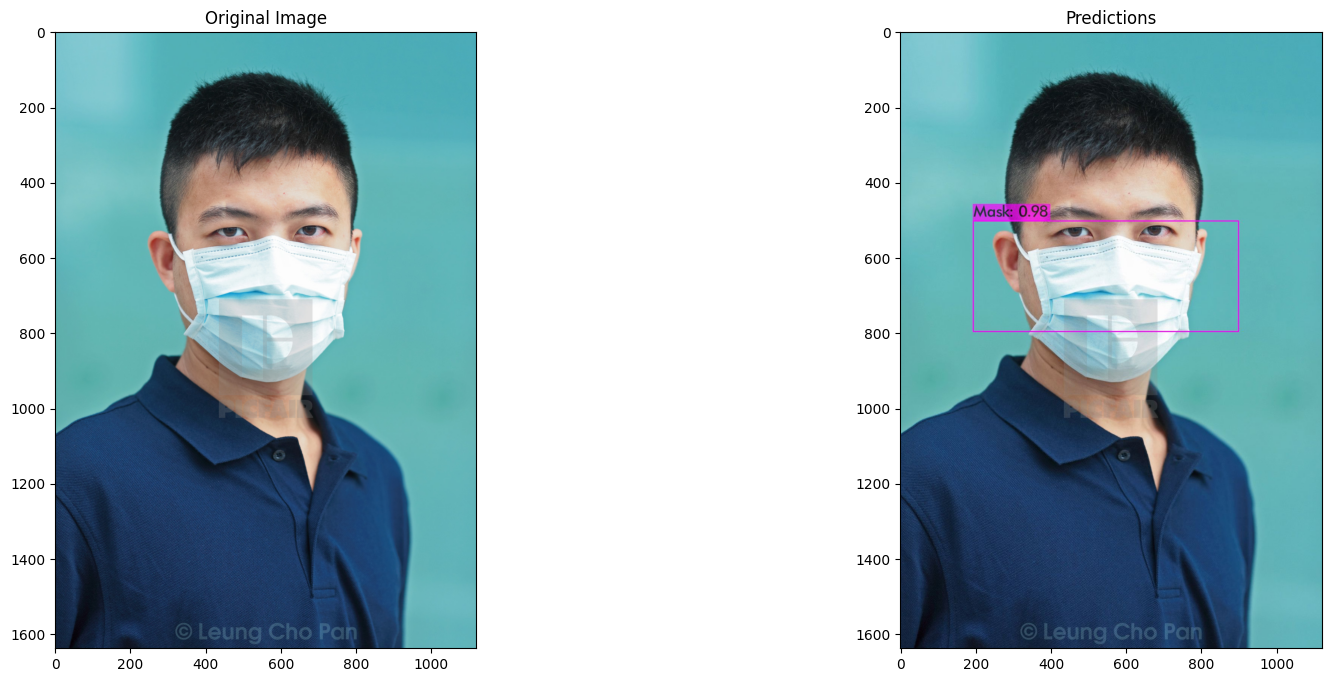

In [10]:
!./darknet detector test yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-image1.jpg -thresh .7 2> /dev/null
display_output("test-image1.jpg")

### <font style="color:green">9.2. Test Image 2</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 17 K-images (0 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test-image2.jpg: Predicted in 138.708000 milli-seconds.
Mask: 65%
No-Mask: 40%
Mask: 82%
No-Mask: 42%
No-Mask: 95%


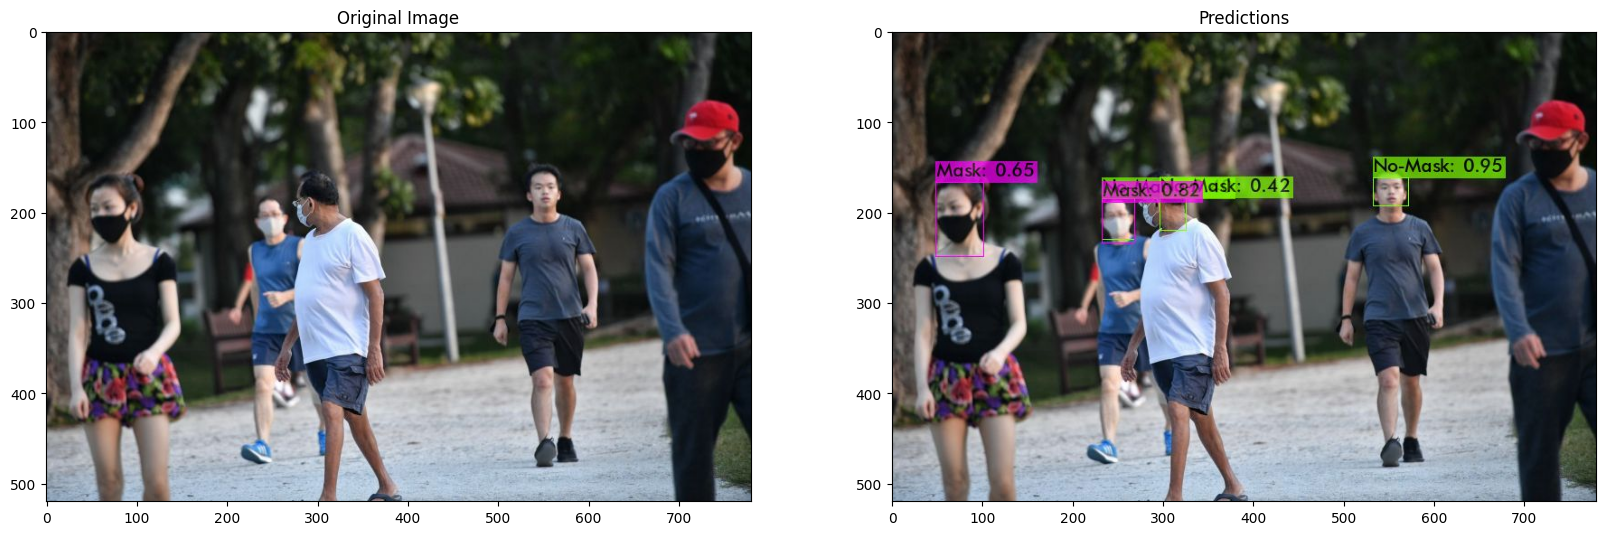

In [21]:
!./darknet detector test yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-image2.jpg -thresh .4  2> /dev/null
display_output("test-image2.jpg")

### <font style="color:green">9.3. Test Image 3</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 17 K-images (0 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test-image3.jpg: Predicted in 106.949000 milli-seconds.
Mask: 96%
No-Mask: 41%
Mask: 81%
No-Mask: 24%
Mask: 99%
Mask: 97%
Mask: 90%
Mask: 23%
Mask: 68%
Mask: 85%
Mask: 61%
Mask: 99%
Mask: 57%
Mask: 96%
Mask: 99%
Mask: 31%
Mask: 89%
Mask: 91%


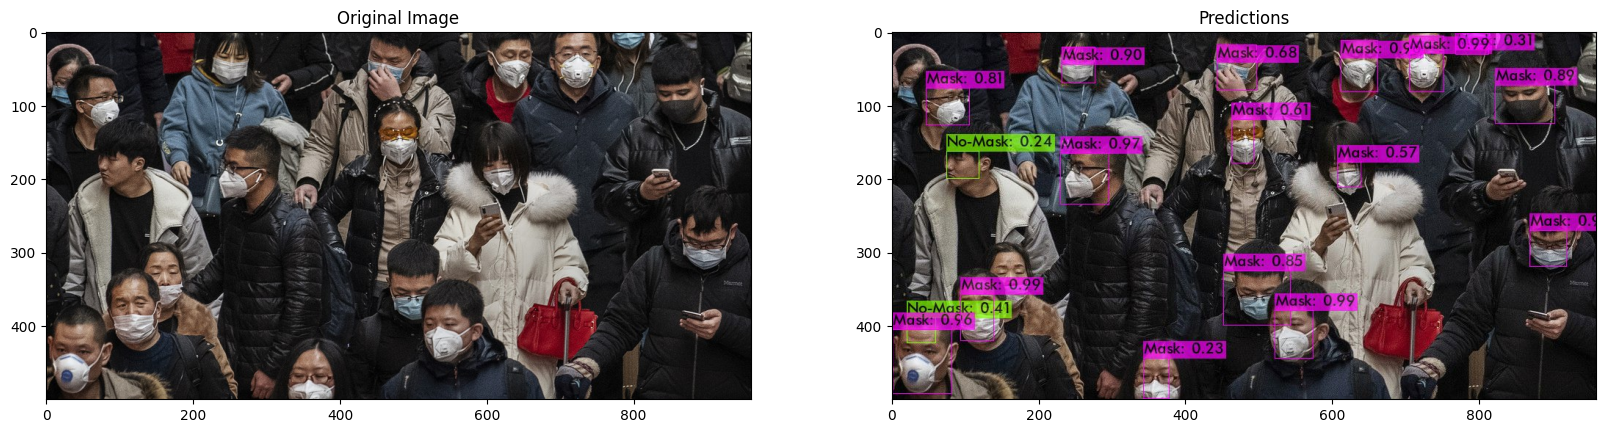

In [13]:
!./darknet detector test yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-image3.jpg -thresh .2  2> /dev/null
display_output("test-image3.jpg")

### <font style="color:green">9.4. Test Image 4</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 17 K-images (0 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test-image4.jpg: Predicted in 100.146000 milli-seconds.
No-Mask: 82%
No-Mask: 91%
Mask: 68%
Mask: 98%
No-Mask: 75%
Mask: 67%
No-Mask: 53%
Mask: 99%


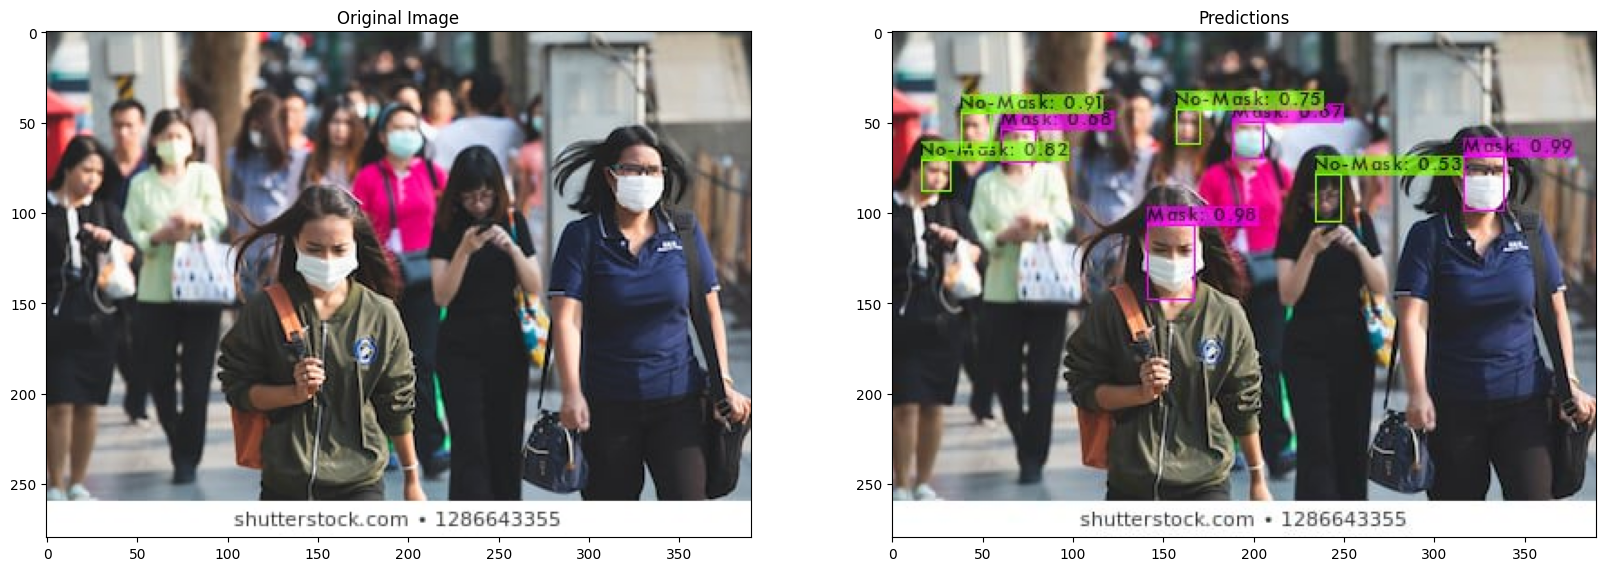

In [14]:
!./darknet detector test yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-image4.jpg -thresh .4 2> /dev/null
display_output("test-image4.jpg")

In [15]:
!./darknet detector demo yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-video1.mp4 -thresh .4 -out_filename out-vid1.avi -dont_show

Se han truncado las últimas 5000 líneas del flujo de salida.
Mask: 82% 
Mask: 47% 

FPS:33.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 95% 
Mask: 90% 
Mask: 78% 
Mask: 52% 

FPS:33.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 95% 
Mask: 90% 
Mask: 78% 
Mask: 53% 

FPS:33.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 95% 
Mask: 93% 
Mask: 75% 
Mask: 58% 

FPS:33.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 93% 
Mask: 93% 
Mask: 83% 
Mask: 63% 

FPS:34.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 94% 
Mask: 93% 
Mask: 90% 
Mask: 60% 

FPS:33.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 94% 
Mask: 93% 
Mask: 92% 
Mask: 60% 

FPS:33.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 96% 
Mask: 94% 
Mask: 92% 
Mask: 67% 

FPS:33.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 96% 
Mask: 94% 
Mask: 92% 
Mask: 67% 

FPS:33.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-

In [17]:
!./darknet detector demo yolov3-mask.data yolov3-mask-test.cfg backup/yolov3-mask-train_best.weights test-video2.mp4 -thresh .2 -out_filename out-vid2.avi -dont_show

Se han truncado las últimas 5000 líneas del flujo de salida.
Mask: 27% 

FPS:33.9 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 36% 
No-Mask: 24% 
Mask: 78% 

FPS:34.3 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 36% 
No-Mask: 23% 
Mask: 73% 

FPS:34.7 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 52% 
Mask: 90% 

FPS:34.2 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 38% 
No-Mask: 35% 
Mask: 60% 

FPS:34.6 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 60% 
No-Mask: 25% 
No-Mask: 21% 
Mask: 69% 

FPS:34.9 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 64% 
No-Mask: 39% 
Mask: 92% 

FPS:35.3 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 60% 
No-Mask: 41% 
No-Mask: 28% 
Mask: 75% 

FPS:35.5 	 AVG_FPS:34.1

 cvWriteFrame 
Objects:

No-Mask: 58% 
No-Mask: 40% 
No-Mask: 28% 
Mask: 73% 

FPS:35.7 	 AVG_FPS:32.3

 cvWriteFrame 
Objects:

No-Mask: 47% 
No-Mask: 39% 
Mask: 72% 

FPS:35.9 	 AVG_FPS:32.3

 cvWriteFrame 
Objects:

No-Mask: 35% 
No-Mask: 34% 

FPS:36.1 	